# Image classification using PyTorch library

A simple classification excercise to identify images of cats and dogs using PyTorch ans study it's various functionalities.
The dataset is taken from kaggle which is contributed by sachin.
There are a total of 12500 images of cats and dogs respectively.

In [4]:
#Importing necessary libraries
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

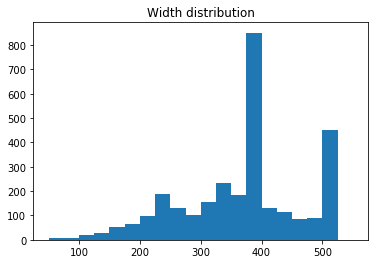

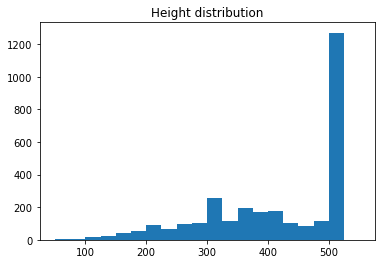

In [5]:
#Collecting desciptive stats of image dimensions

width = []
height = []
file = os.listdir('data/cvd/PetImages/cats_and_dogs')
folder = r'data\cvd\PetImages\cats_and_dogs'
for i in range(len(file)):
    image_path = os.path.join(folder,file[i])
    img = mpimg.imread(image_path)
    width.append(img.shape[0])
    height.append(img.shape[1])

width_array = np.array(width)
height_array = np.array(height)

mean_width = np.mean(width_array)
mean_height = np.mean(height_array)

plt.hist(width_array,20,(50,550))
plt.title('Width distribution')
plt.show()

plt.hist(height_array,20,(50,550))
plt.title('Height distribution')

plt.show()

In [6]:
#Creating a custom dataset class that extends from torch.utils.data module
class CatsandDogsDataset(Dataset):
    def __init__(self,csv_file,root_dir,transform=None):
        self.annotation = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.annotation)
    
    def __getitem__(self,index):
        image_path = os.path.join(self.root_dir,self.annotation.iloc[index,0])
        #image = io.imread(image_path)
        image = Image.open(image_path)
        y_label = torch.tensor(int(self.annotation.iloc[index,1]))
        #f_name = self.annotation.iloc[index,0]
        if self.transform:
            image = self.transform(image)
        
        return (image,y_label)#,f_name)

In [7]:
#A subset of 2990 images are used for training and testing the network
dataset = CatsandDogsDataset(
    csv_file='/pytorch/data/cvd/PetImages/labels2.csv',
    root_dir='/pytorch/data/cvd/PetImages/cats_and_dogs',
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor()]))

In [ ]:
#Loop to check if all images have R,G,B layers. Some images considered had faulty dimensions.
#These were eventually deleted based on names of files displayed by the below loop
for image,label,f_name in dataset:
  if image.shape[0] != 3:
    print(image.shape,label,f_name)

In [9]:
train_set,val_set = torch.utils.data.random_split(dataset,[2900,90])

In [10]:
#Creating a loader object from the split dataset.This function wraps an iterable over the dataset object
train_loader = torch.utils.data.DataLoader(train_set,batch_size=32,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set,batch_size=32,shuffle=True)

In [11]:
#importing a pretrained Alexnet network which is provided by PyTorch
import torchvision.models as models
model = models.alexnet(pretrained=True)

In [12]:
#Freezing parameters of the sequential part called 'features' 
for params in model.features.parameters():
  params.requires_grad = False

In [13]:
#Modifying the layers of the classifier part to output only 2 class labels as need for this task
model.classifier = nn.Sequential(
    nn.Linear(9216,4096),
    nn.ReLU(),
    nn.Linear(4096,1024),
    nn.ReLU(),
    nn.Linear(1024,2)
)

In [14]:
#Creating the loss condition and optimiser
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [15]:
#Setting up the training and validation loop
import time
start_time = time.time()

epochs = 3
train_losses = []
train_correct = []

for i in range(epochs):
    trn_corr = 0
    val_corr = 0
 
    for b,(X_train,y_train) in enumerate(train_loader):
        b += 1
        optimizer.zero_grad()
        #X, y = X_train.to(device), y_train.to(device) ---------TO be used when GPU is available
        
        y_pred = model(X_train)
        loss = criterion(y_pred,y_train)
        
        predicted = torch.max(y_pred.data,1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        loss.backward()
        optimizer.step()
        
        if b%30 == 0:
            print(f'epoch: {i:2} batch: {b:4} [{32*b:6}/2900] loss: {loss.item():10.8f} | accuracy: {trn_corr.item()*100/(32*b):7.3f}')
            
        train_losses.append(loss)
        train_correct.append(trn_corr)
        
    if i%2 == 0:
        for bat,(X_val,y_val) in enumerate(val_loader):
            bat+=1
            with torch.no_grad():
                y_val_pred = model(X_val)
                loss = criterion(y_val_pred,y_val)
                    
                predicted = torch.max(y_val_pred.data,1)[1]
                batch_corr = (predicted == y_val).sum()
                val_corr += batch_corr

        print(f'val --> epoch: {i:2} | loss: {loss.item():10.8f} | accuracy: {val_corr*100/96:7.3f}')
                    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')
            


epoch:  0 batch:   30 [   960/2900] loss: 0.28822932 | accuracy:  73.646
epoch:  0 batch:   60 [  1920/2900] loss: 0.34969041 | accuracy:  82.031
epoch:  0 batch:   90 [  2880/2900] loss: 0.24607244 | accuracy:  84.479
val --> epoch:  0 | loss: 0.46450332 | accuracy:  79.000
epoch:  1 batch:   30 [   960/2900] loss: 0.25332367 | accuracy:  94.896
epoch:  1 batch:   60 [  1920/2900] loss: 0.10097232 | accuracy:  94.427
epoch:  1 batch:   90 [  2880/2900] loss: 0.20255177 | accuracy:  94.236
epoch:  2 batch:   30 [   960/2900] loss: 0.03409335 | accuracy:  97.188
epoch:  2 batch:   60 [  1920/2900] loss: 0.30338097 | accuracy:  96.823
epoch:  2 batch:   90 [  2880/2900] loss: 0.11988381 | accuracy:  96.354
val --> epoch:  2 | loss: 0.34854141 | accuracy:  85.000

Duration: 439 seconds


In [16]:
testset = CatsandDogsDataset(
    csv_file='/pytorch/data/cvd/PetImages/test_labels.csv',
    root_dir='/pytorch/data/cvd/PetImages/test',
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor()]))

In [17]:
test_loader = torch.utils.data.DataLoader(testset,batch_size=30,shuffle=True)

In [18]:
preds = []

for b,(x_test,y_test) in enumerate(test_loader):
    with torch.no_grad():
    #X,y = x_test.to(device),y_test.to(device)
        y_pred = model(x_test)
        predicted = torch.max(y_pred.data,1)[1]
        preds.append(predicted)
        print(predicted)

tensor([0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0,
        0, 0, 1, 0, 1])


In [19]:
test_corr = 0
for i in range(len(y_test)):
  if y_test[i].item() == preds[0][i].item():
    test_corr+=1


In [20]:
print(f'Test accuracy: {test_corr*100/29:5.3f}')
print(f'Number of correct classifications: {test_corr:3}')

Test accuracy: 89.655
Number of correct classifications:  26
